# **Classifying Large Language Model (LLM) generated and Human written text**

**Team: 보건이의 낙곱새**
*   2020320085 컴퓨터학과 조강우
*   2020320148 컴퓨터학과 우인서



**Contents**
1.   Domain & Business Understanding
2.   Data Understanding & Preparation
3.   Modeling
4.   Evaluation
5.   Presentation
6.   Feedback
7.   +Cookie contents(TF-IDF)

## **I. Domain & Business Understanding**

In 2023, the emergence of Large Language Models and the rising popularity of ChatGPT significantly changed multiple aspects of people’s lives. Recently, these models have developed to the point where they are able to generate various forms of text, such as novels, papers, and articles, to a point arguably indistinguishable level. These developments offer great potential in various industries, but at the same time pose new challenges to identify the sources (human or machine) of the generated text. Taking a situation that is familiar to us as an example where we submit report assignments in college classes. For instructors, there is a need to distinguish whether the submitted assignments are made by the students themselves or generated by LLM to guarantee academic integrity. Another reason for the need to distinguish LLM generated text is fake news. Incidents that spread fake news using artificial intelligence to achieve political or malicious purposes can be easily encountered in real life. As such, it is clear that for all documents where the truthfulness is critical, finding the source of the text is important.

In this project, we will propose a model for classifying the source of text through a dataset of human and LLM essays on some given topics. We will analyze the data of human and LLM-generated essays to extract some features that dictates the difference in tendency between them. And based on those features, our goal is to create a model that classifies human and LLM-generated texts.

## **II. Data Understanding & Preparation**

In [ ]:
!pip install textstat

import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import string
import seaborn as sns
import textstat
import matplotlib.pyplot as plt

from textstat import flesch_reading_ease, smog_index, gunning_fog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00


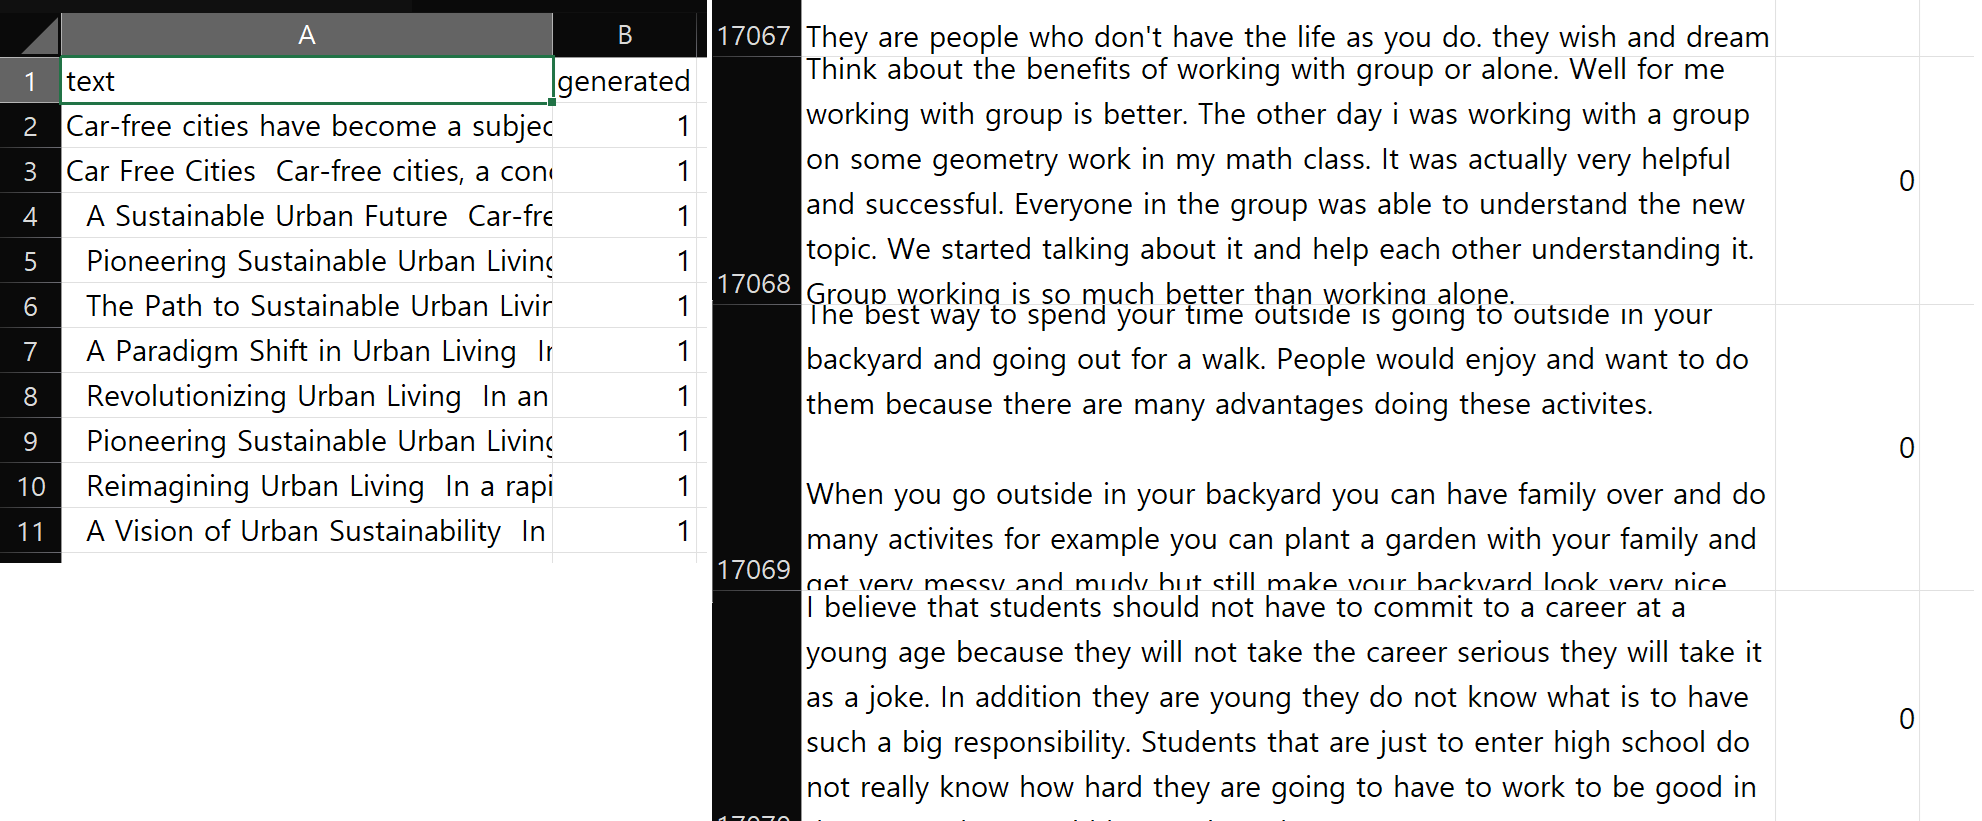

dataset source: https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset

The given data has two labels (text, generated) and around 28,000 objects (essays). Each essay is written in English and is generated from one of seven prompts. There are about 17,000 human written essays and about 11,000 LLM generated essays.

### **A. Data Preprocessing**

All essays in the dataset are in their raw form. Extracting specific features during the modeling stage requires preprocessing to extract only the necessary words. Therefore, we define the preprocess_text function, which tokenizes the essays into word units. Additionally, certain useless characters in the essays need to be removed, such as case distinctions, numbers, and punctuation marks. There are also multiple words that are unnecessary for data analysis, such as stop words. Thus, we have executed the following additional preprocessing steps.

1. Lower caing all words in essay.
2. Removing hyphens(-).
3. Removing numerical characters.
4. Removing punctuation marks.
5. Removing stop words.

In [ ]:
import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download word list for NLTK
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    text = text.replace("-", " ")
    text = ''.join([i for i in text if not i.isdigit()])
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back to a single string
    return ' '.join(tokens)

In [ ]:
# Data load
# https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Training_Essay_Data.csv')
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


### **B. Data Statistics**

To extract the features needed for the model, we considered the key differences observable in our text dataset. Based on heuristics and observations, these are some of the differences we can infer:

Humans are more likely to make spelling mistakes than Large Language Models.
There is a difference in the frequency of emotional word use between human and LLM-generated essays.
Humans can write more clearly and concisely compared to LLMs, making their essays easier to read.

In this regard, let's examine the statistics to see if these observations hold true. Here's what to look at:
1. Spelling error rate
2. Emotion word rate
3. Flesch Reading-Ease score
4. Smog index score
5. Gunning fog score

**1. Error Rate**

Error rate is an indicator of typographical errors in an essay. The text_error_rates function utilizes spellchecker library to check for spelling errors and calculates the rate of errors as the number of typo tokens in the essay divided by the total number of tokens in the essay. A value closer to 0 means fewer typos, while a value closer to 1 means more typos.



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 10.7 MB/s eta 0:00:00


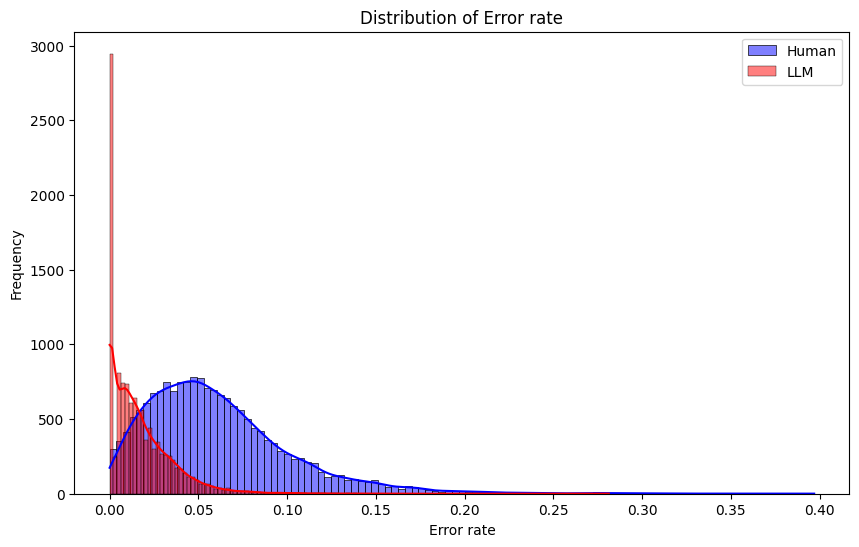

In [ ]:
!pip install pyspellchecker
from spellchecker import SpellChecker
spell = SpellChecker()
def text_error_rates(text):
    texts = preprocess_text(text)
    tokens = word_tokenize(texts)
    if not tokens:
        return 0
    misspelled_words = spell.unknown(tokens)
    return len(misspelled_words) / len(tokens)

df['error_rate'] = df['text'].apply(text_error_rates)

human_error_rate = df[df['generated'] == 0]['error_rate']
llm_error_rate = df[df['generated'] == 1]['error_rate']

plt.figure(figsize=(10, 6))
sns.histplot(human_error_rate, color="blue", kde=True, label='Human', alpha=0.5)
sns.histplot(llm_error_rate, color="red", kde=True, label='LLM', alpha=0.5)
plt.legend()
plt.title('Distribution of Error rate')
plt.xlabel('Error rate')
plt.ylabel('Frequency')
plt.show()


The distribution graph above shows that LLM generated texts tend to have fewer typos, while human written texts tend to have a higher degree of typos.

**2. Emotion Rate**

Emotion rate is an indicator of how often emotional words are used within an essay. As a means of determining how emotional a word is, we used the National Research Council Canada (NRC) Emotion Lexicon.

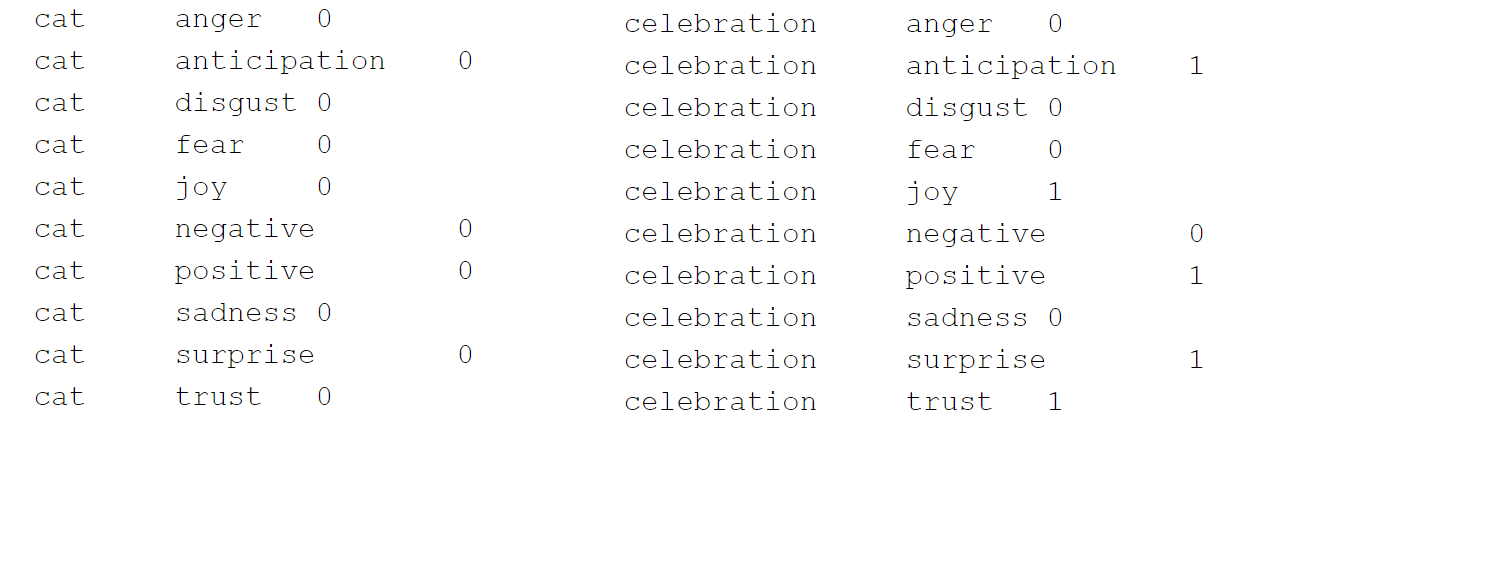

The NRC Emotion Lexicon is a text file, as shown in the picture above. Many words are listed in this lexicon and are given scores based on emotional attributes such as anger, anticipation, disgust, fear, joy, negative, positive, sadness, surprise, and trust. Each emotional attribute has an asymmetric binary value of 0 or 1. As shown in the example above, the word 'cat' scores 0 on all emotional attributes, while 'celebration' scores 1 on anticipation, joy, positive, surprise, and trust, which relatively describes the emotions associated with the word.



The calculate_emotion_scores function computes the emotion score of the text utilizing the NRC Emotion Lexicon. It searches for each token in the essay within the NRC lexicon and calculates the sum total of emotion attribute scores. A higher emotion score implies that the text is more emotional.

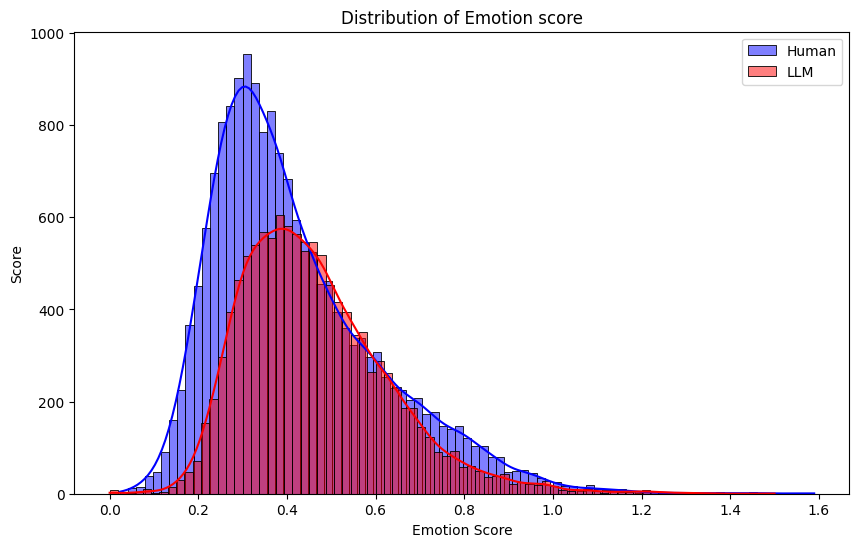

In [ ]:
# NRC emotion lexicon load
# https://github.com/aditeyabaral/lok-sabha-election-twitter-analysis/blob/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
nrc_lexicon = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', header=None, names=['word', 'emotion', 'association'])

# Convert the lexicon into dictionary form
nrc_dict = {}
for i in range(len(nrc_lexicon)):
    word = nrc_lexicon.iloc[i]['word']
    emotion = nrc_lexicon.iloc[i]['emotion']
    association = nrc_lexicon.iloc[i]['association']
    if word not in nrc_dict:
        nrc_dict[word] = {}
    nrc_dict[word][emotion] = association

# Emotion score calculation function
def calculate_emotion_scores(text):
    text = preprocess_text(text)
    words = word_tokenize(text)
    if not words:  # Add a check to prevent division by zero
        return 0
    emotion_scores = {emotion: 0 for emotion in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']}
    for word in words:
        if word in nrc_dict:
            for emotion in nrc_dict[word]:
                emotion_scores[emotion] += nrc_dict[word][emotion]
    return sum(emotion_scores.values()) / len(words)

df['emotion_score'] = df['text'].apply(calculate_emotion_scores)

human_emotion_score = df[df['generated'] == 0]['emotion_score']
llm_emotion_score = df[df['generated'] == 1]['emotion_score']

plt.figure(figsize=(10, 6))
sns.histplot(human_emotion_score, color="blue", kde=True, label='Human', alpha=0.5)
sns.histplot(llm_emotion_score, color="red", kde=True, label='LLM', alpha=0.5)
plt.legend()
plt.title('Distribution of Emotion score')
plt.xlabel('Emotion Score')
plt.ylabel('Score')
plt.show()

Based on the distribution graph above, there appears to be a slight difference in emotional expression between human-written essays and LLM-generated essays. Interestingly, LLM-generated essays exhibit higher emotion scores compared to human-written essays.

**3. Readability scores**

We'll use the Flesch Reading-Ease, smog index, and gunning fog index as statistical indicators to see how difficult a written text is. All three are indicators of the readability of a text.

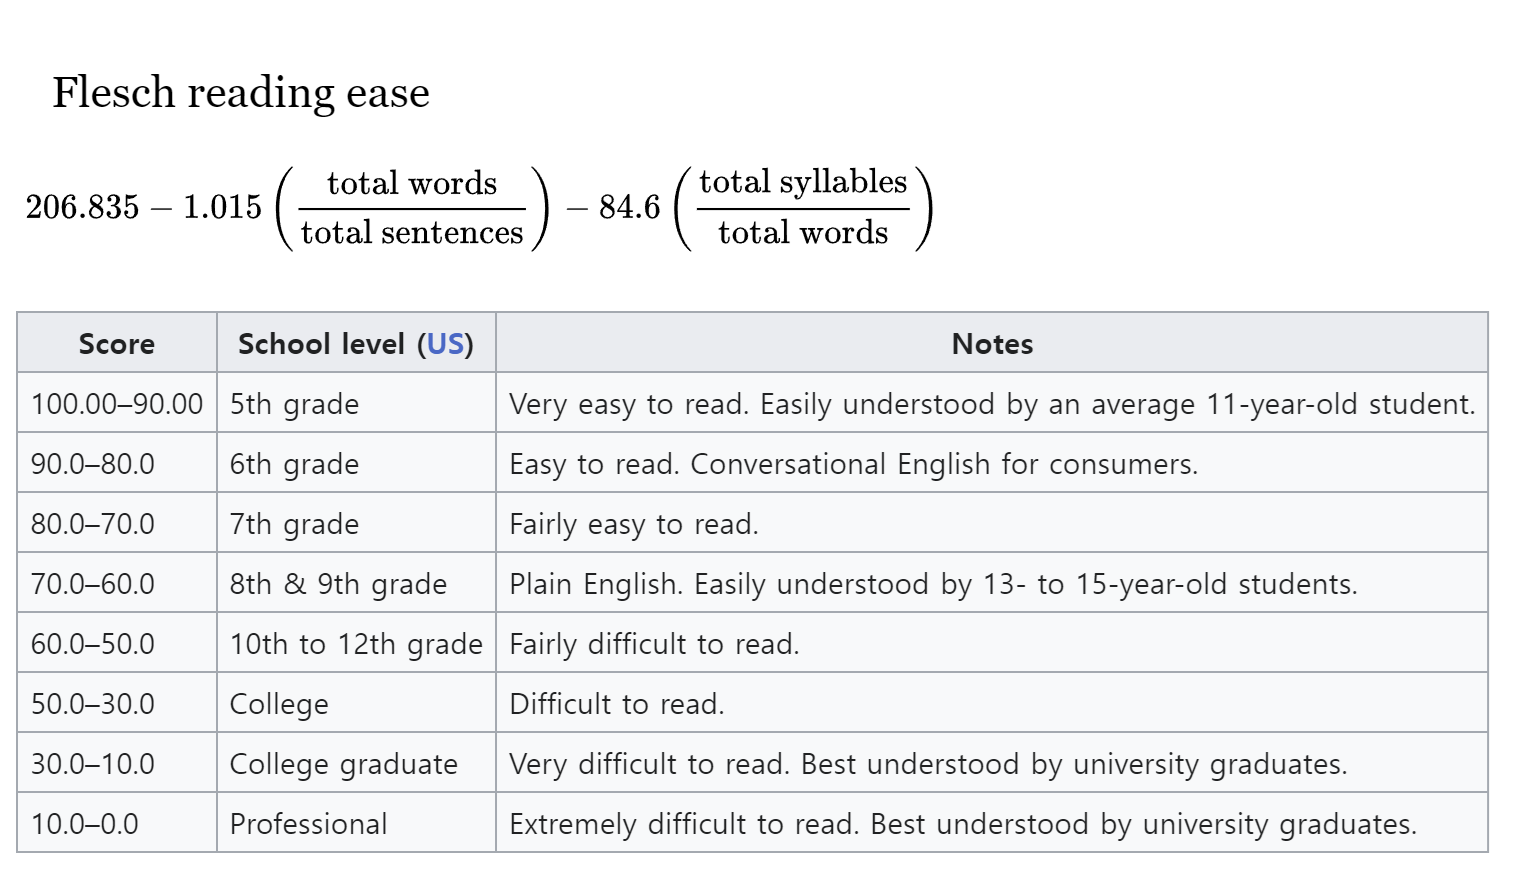

The Flesch Reading-Ease is a measure of text readability. Scores range from 1 to 100, with higher numbers indicating easier readability. The calculation considers total sentences, total words, and total syllables. Typically, texts with fewer sentences, words, and syllables are easier to read and thus result in higher Flesch Reading-Ease scores.

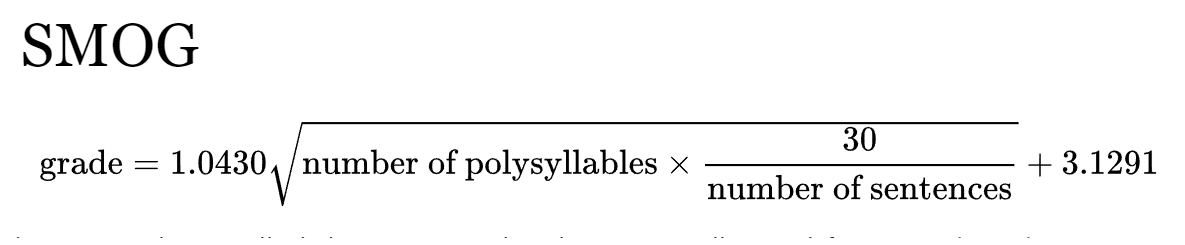

The index estimates the number of years of education a person needs to understand a text. The SMOG index is calculated by counting the number of polysyllabic words (words with three or more syllables) in a sample passage and applying the formula shown above. A higher SMOG Index score indicates a more challenging text to read, suggesting a higher level of education required for comprehension.

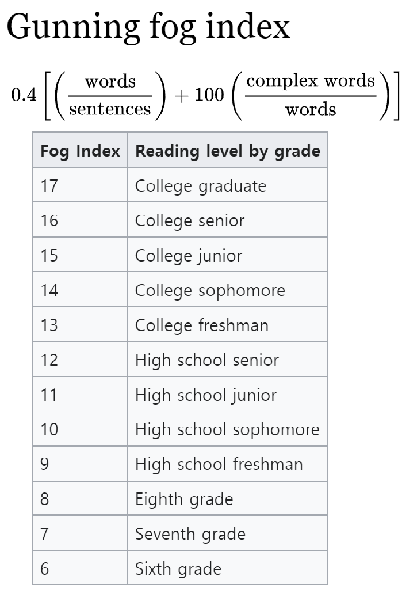

The Gunning Fog Index serves as an indicator of a text's reading difficulty. It is calculated based on average sentence length and the percentage of complex words. A higher score indicates that the text is more complex and requires a higher level of formal education to comprehend. For instance, a text with a Fog Index score of 10 would typically require the reader to be at least a high school sophomore level to understand it.

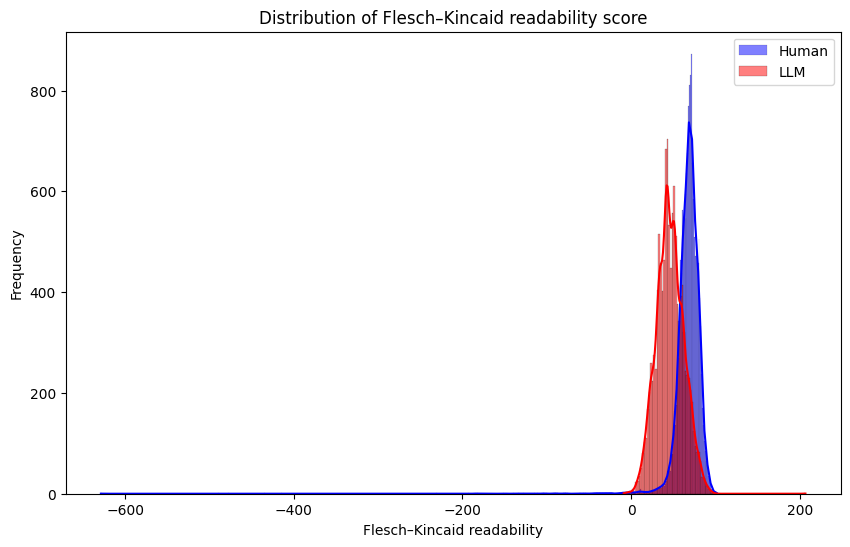

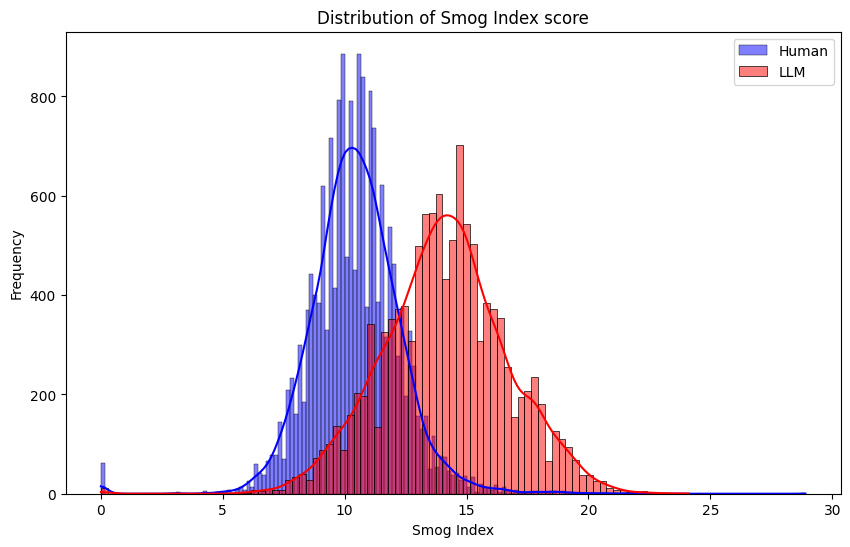

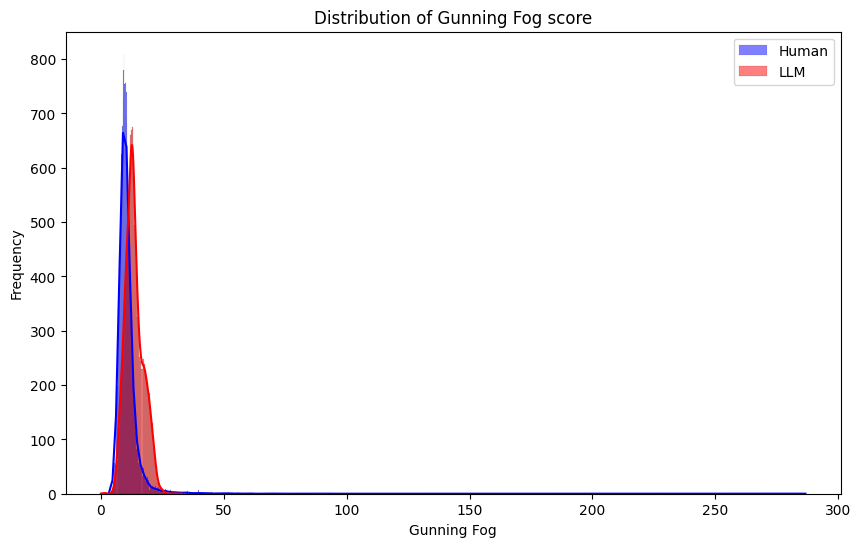

In [ ]:
features_to_plot = ['Flesch–Kincaid readability', 'Smog Index', 'Gunning Fog']
df['Flesch–Kincaid readability'] = df['text'].apply(textstat.flesch_reading_ease)
df['Smog Index'] = df['text'].apply(textstat.smog_index)
df['Gunning Fog'] = df['text'].apply(textstat.gunning_fog)
human_score = df[df['generated'] == 0]
llm_score = df[df['generated'] == 1]

for feature in features_to_plot:
  plt.figure(figsize=(10, 6))
  sns.histplot(human_score[feature], color="blue", kde=True, label='Human', alpha=0.5)
  sns.histplot(llm_score[feature], color="red", kde=True, label='LLM', alpha=0.5)
  plt.legend()
  plt.title(f'Distribution of {feature} score')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

The three distribution graphs above shows a significant and meaningful distribution difference. All three index suggests that LLM generated essays are more difficult to read than human written texts.


## **III. Modeling**

### **A. Extracting Features**

It was confirmed that all five features we analyzed in data statistics showed significant differences in distribution between human written and LLM-generated essays. Therefore, we intend to use these indicators as features for classification.

1. Error rate
2. Emotion rate
3. Flesch Reading-Ease
4. Smog index
5. Gunning fog

In [ ]:
def extract_features(text):
    features = {}
    features['error_rate'] = text_error_rates(text)
    features['emotion_rate'] = calculate_emotion_scores(text)
    features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    features['smog_index'] = textstat.smog_index(text)
    features['gunning_fog'] = textstat.gunning_fog(text)
    return features

### **B. Train and test a Support Vectore Machine**

We will use a Support Vector Machine (SVM) to classify whether an essay is written by a human or generated by an LLM. For evaluation, we plan to use hold-out evaluation, so we randomly partition the existing dataset into a training set and a test set in an 8:2 ratio. The training set will be used for modeling, while the test set will be used for evaluating the model.

In [ ]:
df_features = df['text'].apply(extract_features)
normalized_features = pd.json_normalize(df_features)

# Proceed with model training
X = normalized_features
y = df['generated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

## **IV. Evalutaion**

To evaluate the classification performance of the SVM model we designed, we will examine the confusion matrix and consider precision, recall, F1-score, and accuracy indicators.

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3539
           1       0.91      0.86      0.88      2290

    accuracy                           0.91      5829
   macro avg       0.91      0.90      0.90      5829
weighted avg       0.91      0.91      0.91      5829



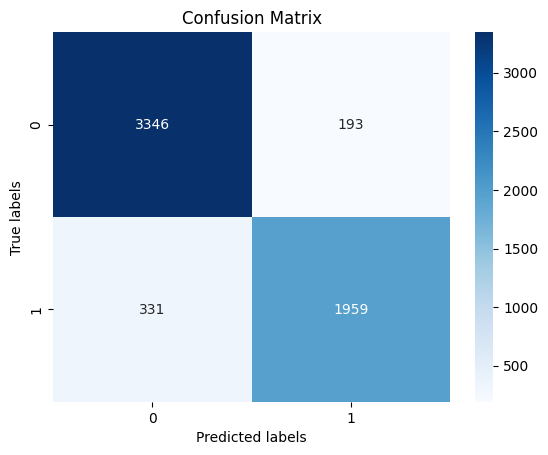

In [ ]:
predictions = svm_model.predict(X_test)
print(classification_report(y_test, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Overall, the model demonstrates high values for precision, recall, F1-score, and accuracy. Both classes exhibit relatively high performance indicators, particularly class 0, which shows that the model is effective at detecting most positive cases.

## **V. Presentation**

The model uses five features as attributes in classifying the text data. Therefore, we need to reduce the dimensionality of these attributes to visualize our model. We used Principal Component Analysis (PCA), a linear dimensionality reduction technique, for this purpose. All the attributes are transformed onto new coordinates with two principal components as axes.

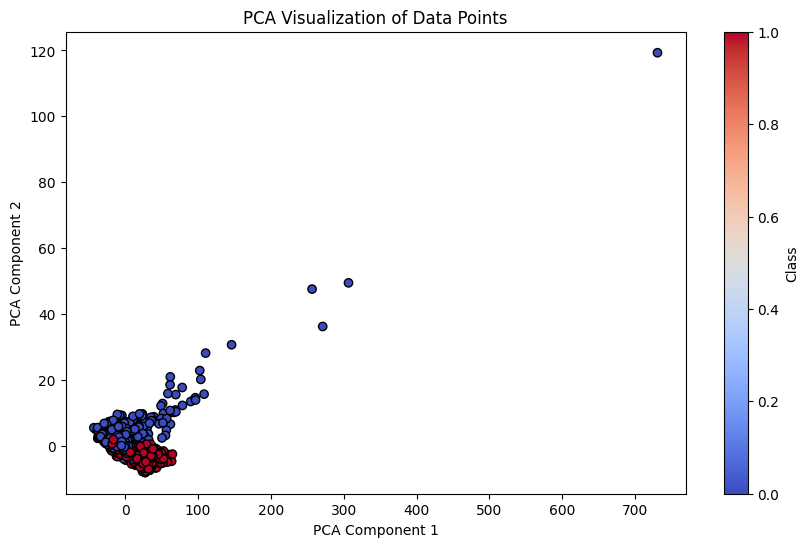

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA

# Define features to plot
features_to_plot = ['error_rate', 'emotion_rate', 'flesch_reading_ease', 'smog_index', 'gunning_fog']

pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_test)

# Plot PCA-reduced data
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='coolwarm', edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Data Points')
plt.colorbar(label='Class')
plt.show()

## **VI. Feedback**

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3539
           1       0.91      0.86      0.88      2290

    accuracy                           0.91      5829
   macro avg       0.91      0.90      0.90      5829
weighted avg       0.91      0.91      0.91      5829



Let's review the evaluation results of our model shown above. The model demonstrates high precision, recall, F1-score, and accuracy overall. However, it performs better in classifying human-written essays compared to LLM-generated essays, as indicated by the recall and F1-score. This means that among the actual positive cases, class 0 (human-written) is well-detected, whereas class 1 (LLM-generated) is somewhat more challenging to detect.

One reason for this phenomenon is the class imbalance within the dataset. In the dataset we used, there are about 17,000 human-written essays and about 11,000 LLM-generated essays. Since the model is trained with more human-written essays than LLM-generated essays, the human class has a relatively higher evaluation value. To achieve better results, it would be beneficial to use a dataset with a balanced distribution of classes.

Another reason is the selection of features. It appears that the features we chose for modeling are advantageous for classifying class 0 but are less effective for classifying class 1.

Let's consider the error rate among the features we chose as an example. The distribution of error rates shows a clear difference between human and LLM-generated texts. However, there is something we missed. The given distribution can lead to the rough conclusion that "LLMs do not make typographical errors" and "Essays with typographical errors are written by humans." However, this does not conclusively tell us that "Essays without typographical errors is written by an LLM." If a person is careful in their writing, their essay may not have any typographical errors. In other words, a high error rate strongly indicates that an essay is written by a human, but a low error rate does not provide significant information.

While a high error rate may be useful for detecting human-written essays, there are limitations in detecting LLM-generated essays. Therefore, we need a more powerful and decisive feature to improve the classification of LLM-generated essays and address the limitations of our current model.

 Additionally, a plan is required to address the outliers present in the modeling results. In the previous PCA visualization graph, there were data points that were excessively distant from the others. This is presumed to be due to the presence of outliers in the Flesch–Kincaid readability and Gunning Fog metrics. In order to achieve better modeling, it is necessary to devise an effective method to remove these outliers.

## **VII.   +Cookie contents(TF-IDF)**

The initial approach we took was based on our research on existing methods of classifying two different sets of text data. We attempted to use TF-IDF (Term Frequency-Inverse Document Frequency), which is a method used in information retrieval. It measures the importance of a word to a document in a collection or corpus, adjusted for the fact that some words appear more frequently in general.

The intuition behind this approach is to identify words that appear frequently in a text but are offset by the number of texts that contain the same words. For example, stopwords such as 'a', 'an', and 'the' appear frequently in all text data, meaning they don't have significant relevance. However, if a certain word appears frequently in a specific set of texts, then we can infer its relevance among those texts.

This can be applied in the classification of human-written texts and LLM-generated texts. We can argue that there are certain words that frequently appear in human-written texts but not in LLM-generated texts, and vice versa.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Data load
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Training_Essay_Data.csv')

# Dataset Splitting
train_x, test_x, train_y, test_y = train_test_split(df['text'], df['generated'], test_size=0.2, random_state=42)

# TF-IDF vectorizer initialization and learning on training data
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_x)

# Test data conversion
X_test_tfidf = tfidf_vectorizer.transform(test_x)

# SVM model initialization and training
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, train_y)

# Evaluation
predictions = svm_model.predict(X_test_tfidf)
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3539
           1       1.00      0.98      0.99      2290

    accuracy                           0.99      5829
   macro avg       0.99      0.99      0.99      5829
weighted avg       0.99      0.99      0.99      5829



Utilizing the TF-IDF vectorizer to extract relevant attributes and training a SVM with those attributes yields a significantly accurate model.

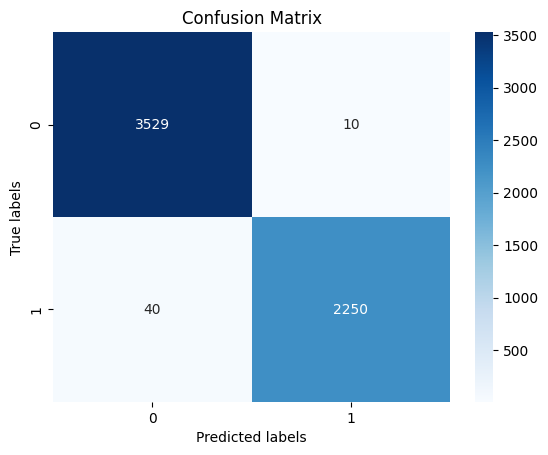

In [ ]:
cm = confusion_matrix(test_y, predictions)

# Confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Top positive coefficient values:
[2.43741851 2.50045256 2.50480429 2.53155022 2.53973441 2.64036138
 2.67558507 3.17868138 3.25463597 3.87435022]

Top negative coefficient values:
[-5.33109412 -3.14071458 -2.9893375  -2.83640027 -2.66764646 -2.66586615
 -2.57457644 -2.5268608  -2.19386868 -2.1649103 ]


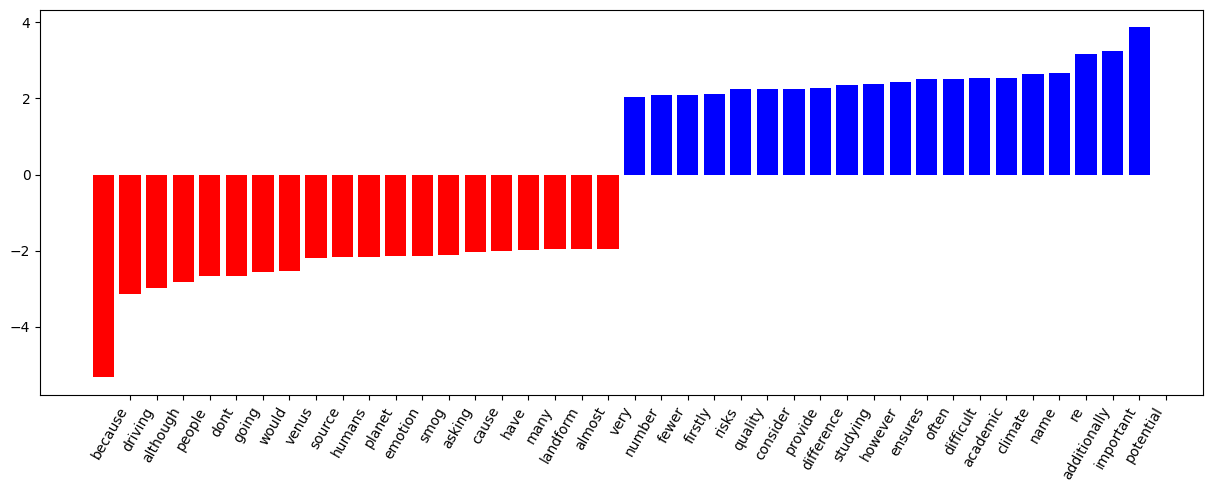

In [ ]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

svm_coef = svm_model.coef_.toarray()

top_positive_coefficients = np.argsort(svm_coef[0])[-10:]
top_negative_coefficients = np.argsort(svm_coef[0])[:10]

print("\nTop positive coefficient values:")
print(svm_coef[0][top_positive_coefficients])

print("\nTop negative coefficient values:")
print(svm_coef[0][top_negative_coefficients])

def visualize_coefficients(classifier, feature_names, n_top_features=20):
    coef = classifier.coef_.toarray().ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right")
    plt.show()

visualize_coefficients(svm_model, tfidf_vectorizer.get_feature_names_out())

Below are the top 10 most relevant features or words that appear in our text data. From this, we can infer that the reason the model works really well is that humans tend to use a different set of words compared to LLMs, and vice versa.